In [255]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql.functions import abs as abs_col
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

spark = (
    SparkSession.builder
    .appName("Big Data Analytics")
    .master("local2")
    .config("spark.driver.host", '127.0.0.1')
    .getOrCreate()
)

In [256]:
# Ingest data into Postgres
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db passwor
db_properties['password']= "1234"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa.players_engineered"

In [257]:
df_read = spark.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(10)

+-------+---------+---+---------+---------+------------+--------------+---------+-----------+------------------------+-------------+----------------+----+-------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------------+---------------------+---------------------+----------------+------------------+----------------+-------------+-------------+--------------+--------------------+-----------------------+---------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+------------------+------------------+---+
|overall|potential|age|height_cm|weight_kg|league_level|preferred_foot|weak_foot|skill_moves|international_reputation|    work_rate|       body_type|pace|passing|defending|physic|attacking_crossing|attacking_finishing|attacki

In [258]:
# truncated_df = df_read.sample(0.1)
# truncated_df = truncated_df.toPandas()
# truncated_df.to_csv('data_engineering_pytorch.csv', index=False)

## Prepare for MLP training

In [259]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

string_cols = ['preferred_foot','work_rate', 'body_type']
for col in string_cols:
    print(df_read.select(col).distinct().show())

indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in string_cols]
encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_vec") for column in string_cols]

pipeline = Pipeline(stages=indexers + encoders)

df_transformed = pipeline.fit(df_read).transform(df_read)

+--------------+
|preferred_foot|
+--------------+
|          Left|
|         Right|
+--------------+

None
+-------------+
|    work_rate|
+-------------+
|Medium/Medium|
|  High/Medium|
|     Low/High|
|      Low/Low|
|    High/High|
|   Medium/Low|
|     High/Low|
|  Medium/High|
|   Low/Medium|
+-------------+

None
+----------------+
|       body_type|
+----------------+
|   Stocky (170-)|
|   Normal (185+)|
|     Lean (185+)|
|Normal (170-185)|
|     Lean (170-)|
|  Lean (170-185)|
|   Normal (170-)|
|   Stocky (185+)|
|Stocky (170-185)|
|          Unique|
+----------------+

None


In [260]:
# Vector Assmebling steps
from pyspark.ml.feature import VectorAssembler

feature_cols = df_transformed.drop('preferred_foot', 'overall', 'work_rate', 'body_type', 'preferred_foot_index', 'work_rate_index', 'body_type_index', 'UID').columns
print(feature_cols)

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_assembled = vector_assembler.transform(df_transformed)

['potential', 'age', 'height_cm', 'weight_kg', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'passing', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'log_value_eur', 'log_wage_eur', 'preferred_foot_vec', 'work_rate_vec', 'body_type_vec']


In [261]:
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.sql.functions import udf
import pandas as pd
train, test = df_assembled.randomSplit([0.7, 0.3], seed=504)

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
train_pd = train.withColumn("features", to_array("features")).toPandas()
test_pd = test.withColumn("features", to_array("features")).toPandas()

In [262]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

x_train = torch.from_numpy(np.array(train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_pd['overall'].values.tolist(), np.int64))

x_test = torch.from_numpy(np.array(test_pd['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_pd['overall'].values.tolist(), np.int64))

In [263]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

## First MLP Structure

In [264]:
class myNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 64)
        self.ln2 = nn.Linear(64, 32)
        self.ln3 = nn.Linear(32, 1)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = self.ln3(x)
        return x


In [265]:
input_size = x_train.shape[1]
model = myNeuralNet(input_size)

batch_size = 128
num_epochs = 150
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)
loss_fcn = nn.MSELoss()

loss_per_batch = []
train_loss = []
test_loss = []
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    model = model.train()

    # Compute the train/validate/accuracy for each epoch and save the best model so far every epoch
    total_train_loss = 0
    total_test_loss = 0
    for batch_id, (x,y) in enumerate(train_loader):
        opt.zero_grad()
        output = model(x)
        output = output.squeeze().float()
        loss = loss_fcn(output, y.float())

        total_train_loss += loss.item()
        loss_per_batch.append(loss.item())
        loss.backward()
        opt.step()
    train_loss.append(total_train_loss / len(train_loader))
    
    # Compute the validation loss
    model = model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    with torch.no_grad():
        for batch_id, (x,y) in enumerate(test_loader):
            output = model(x)
            output = model(x)
            output = output.squeeze().float()
            loss = loss_fcn(output, y.float())
            total_test_loss += loss.item()
    test_loss.append(total_test_loss / len(test_loader))

    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch} train loss: {train_loss[-1]}")
        print(f"Epoch {epoch} test loss: {test_loss[-1]}")
    # Save the best model so far
    
    if epoch == 0:
        best_model = model
        best_epoch = epoch
    elif test_loss[-1] <  __builtins__.min(test_loss[:-1]):
        best_model = model
        best_epoch = epoch
        

    # Early stopping
    if epoch - best_epoch >= 50:
        print("Early stopping at epoch {}".format(epoch))
        break



Epoch 4 train loss: 1.260389825977589
Epoch 4 test loss: 1.1378107467677696
Epoch 9 train loss: 1.0474516672447731
Epoch 9 test loss: 1.2665891477301077
Epoch 14 train loss: 0.8871818418375361
Epoch 14 test loss: 0.7727909202407475
Epoch 19 train loss: 0.8494980330184355
Epoch 19 test loss: 0.834663805237577
Epoch 24 train loss: 0.7569635904052888
Epoch 24 test loss: 0.7990976678995998
Epoch 29 train loss: 0.721891085358611
Epoch 29 test loss: 0.7591844058475612
Epoch 34 train loss: 0.700885704707602
Epoch 34 test loss: 0.6649090719917801
Epoch 39 train loss: 0.6695621733248933
Epoch 39 test loss: 0.6518068139904116
Epoch 44 train loss: 0.6763342535402505
Epoch 44 test loss: 0.7860905447620555
Epoch 49 train loss: 0.6605055770087584
Epoch 49 test loss: 0.6498144460967713
Epoch 54 train loss: 0.6664329526321829
Epoch 54 test loss: 0.8287381059004485
Epoch 59 train loss: 0.6483100304936181
Epoch 59 test loss: 0.6904554767477
Epoch 64 train loss: 0.6325714873754683
Epoch 64 test loss: 0.5

In [266]:

print('Best epoch: {}'.format(best_epoch))
print('Train loss: {}'.format(train_loss[best_epoch]))
print('Test loss: {}'.format(test_loss[best_epoch]))
print('batch size: {}'.format(batch_size))
print('learning rate: {}'.format(lr))
print('number of epochs: {}'.format(num_epochs))

# Best model
best_model = best_model.eval()
print(best_model)

Best epoch: 144
Train loss: 0.5290159618450423
Test loss: 0.47972606195628276
batch size: 128
learning rate: 0.001
number of epochs: 150
myNeuralNet(
  (ln1): Linear(in_features=59, out_features=64, bias=True)
  (ln2): Linear(in_features=64, out_features=32, bias=True)
  (ln3): Linear(in_features=32, out_features=1, bias=True)
)


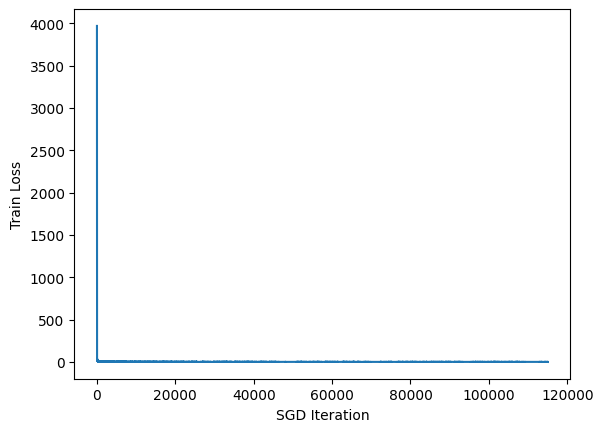

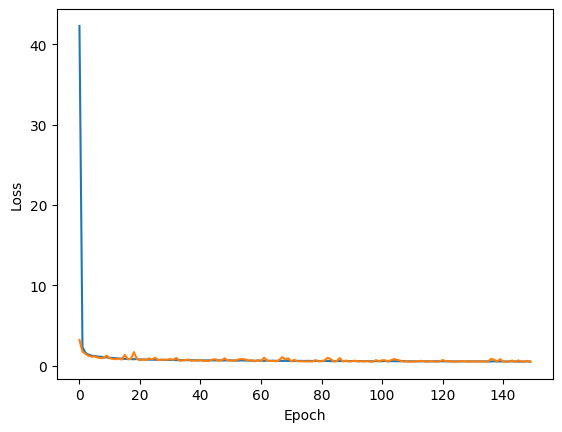

In [267]:
# Train loss per SGD Iteration
import matplotlib.pyplot as plt
plt.plot(range(1, len(loss_per_batch) + 1), loss_per_batch, label='Train Loss per Batch')
plt.ylabel('Train Loss')
plt.xlabel('SGD Iteration')
plt.show()

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Tensorflow MLP

In [268]:
import tensorflow as tf
from tensorflow import keras

x_train = tf.constant(np.array(train_pd['features'].values.tolist()))
y_train = tf.constant(np.array(train_pd['overall'].values.tolist()))

x_test = tf.constant(np.array(test_pd['features'].values.tolist()))
y_test = tf.constant(np.array(test_pd['overall'].values.tolist()))

In [281]:
import datetime
model = keras.Sequential([keras.layers.Dense(64, activation='relu'), 
                            keras.layers.Dense(32, activation='relu'),
                            keras.layers.Dense(16, activation='relu'),
                            keras.layers.Dense(8, activation='relu'),
                            keras.layers.Dense(4, activation='relu'),
                            keras.layers.Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
3066/3066 [==============================] - 2s 554us/step - loss: 10.2638 - mae: 1.5890
Epoch 2/100
3066/3066 [==============================] - 2s 550us/step - loss: 1.4763 - mae: 0.9455
Epoch 3/100
3066/3066 [==============================] - 2s 557us/step - loss: 1.2793 - mae: 0.8787
Epoch 4/100
3066/3066 [==============================] - 2s 547us/step - loss: 1.1853 - mae: 0.8441
Epoch 5/100
3066/3066 [==============================] - 2s 548us/step - loss: 1.0825 - mae: 0.8047
Epoch 6/100
3066/3066 [==============================] - 2s 549us/step - loss: 1.0446 - mae: 0.7915
Epoch 7/100
3066/3066 [==============================] - 2s 549us/step - loss: 0.9864 - mae: 0.7683
Epoch 8/100
3066/3066 [==============================] - 2s 545us/step - loss: 0.9466 - mae: 0.7521
Epoch 9/100
3066/3066 [==============================] - 2s 538us/step - loss: 0.9158 - mae: 0.7400
Epoch 10/100
3066/3066 [==============================] - 2s 546us/step - loss: 0.8941 - mae: 0.732

In [282]:
model.summary()

model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 64)                3840      
                                                                 
 dense_163 (Dense)           (None, 32)                2080      
                                                                 
 dense_164 (Dense)           (None, 16)                528       
                                                                 
 dense_165 (Dense)           (None, 8)                 136       
                                                                 
 dense_166 (Dense)           (None, 4)                 36        
                                                                 
 dense_167 (Dense)           (None, 1)                 5         
                                                                 
Total params: 6625 (25.88 KB)
Trainable params: 6625 

[0.47530290484428406, 0.4993845820426941]